### Exploratory Notebook Trying to Get MHD Orzang Tang looking nice... 


In [1]:

import os

#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import jax
jax.config.update("jax_disable_jit", False)

jax.config.update("jax_debug_nans", True)
print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


/tmp/ipykernel_160004/1581227358.py:10: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


PJRT C API
cuda 12030


In [2]:
#load athena ICs (not used in this version)
import h5py
import jax.numpy as jnp


In [3]:
import diffhydro as dh


eq = dh.equationmanager_mhd.EquationManagerMHD()
eq.mesh_shape=[256,256,1]

In [4]:
def orszag_tang_2d(eq, embed_in_3d: bool = True):
    # use eq.mesh_shape and optional eq.box_size
    import jax.numpy as jnp

    nx, ny = eq.mesh_shape[0], eq.mesh_shape[1]
    nz = eq.mesh_shape[2] if (len(eq.mesh_shape) > 2) else 1
    box_size = getattr(eq, "box_size", (2.0 * jnp.pi, 2.0 * jnp.pi, 1.0))
    Lx, Ly = float(box_size[0]), float(box_size[1])

    x = (jnp.arange(nx) + 0.5) * (Lx / nx)
    y = (jnp.arange(ny) + 0.5) * (Ly / ny)
    X, Y = jnp.meshgrid(x, y, indexing="ij")

    rho0 = 25.0 / (36.0 * jnp.pi)
    p0   =  5.0 / (12.0 * jnp.pi)

    rho = jnp.ones((nx, ny)) * rho0
    u   = -jnp.sin(Y); v = jnp.sin(X); w = jnp.zeros_like(u)
    Bx  = -jnp.sin(1.0*Y); By = 0.5 * jnp.sin(2.0 * X); Bz = jnp.zeros_like(u)
    p   = jnp.ones_like(u) * p0

    W2 = jnp.stack([rho, u, v, w, Bx, By, Bz, p], axis=0)  # (8, nx, ny)

    W = jnp.repeat(W2[..., jnp.newaxis], nz, axis=-1) if embed_in_3d else W2
    U = eq.get_conservatives_from_primitives(W)

    #GLM, not tried
    if getattr(eq, "n_cons", U.shape[0]) == 9 and U.shape[0] == 8:
        psi = jnp.zeros_like(U[0])
        U = jnp.vstack([U, psi[jnp.newaxis, ...]])

    t_final = 0.5
    return U, t_final

In [5]:
gamma = 5 / 3

# spatial domain
box_size = 1.0
num_cells = 512

x = jnp.linspace(0, box_size, num_cells)
y = jnp.linspace(0, box_size, num_cells)
X, Y = jnp.meshgrid(x, y, indexing="ij")

# Initialize state
rho = jnp.ones_like(X) * gamma**2 / (4 * jnp.pi)
P = jnp.ones_like(X) * gamma / (4 * jnp.pi)

V_x = -jnp.sin(2 * jnp.pi * Y)
V_y = jnp.sin(2 * jnp.pi * X)
V_z = jnp.zeros_like(X)

B_0 = 1 / jnp.sqrt(4 * jnp.pi)
B_x = -B_0 * jnp.sin(2 * jnp.pi * Y)
B_y = B_0 * jnp.sin(4 * jnp.pi * X)
B_z = jnp.zeros_like(X)

initial_magnetic_field = jnp.stack([B_x, B_y, B_z], axis=0)


In [6]:
prim = jnp.stack([rho,V_x,V_y,V_z, B_x,B_y,B_z,P])

In [7]:
prim = prim[:,:,:,jnp.newaxis]

In [8]:
IC,_ = orszag_tang_2d(eq)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


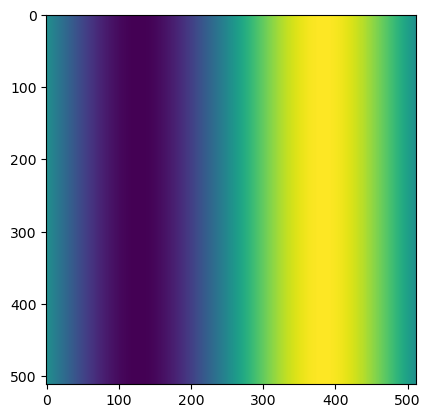

In [9]:
%pylab inline
imshow(prim[-4])

In [10]:
from diffhydro.solver.riemann_solver import RiemannSolver

KOREN
using CT? True
using CT? True
using CT? True


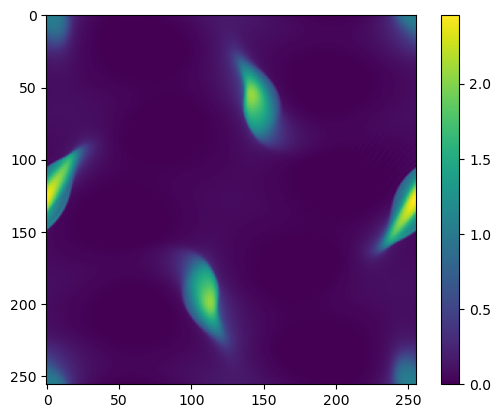

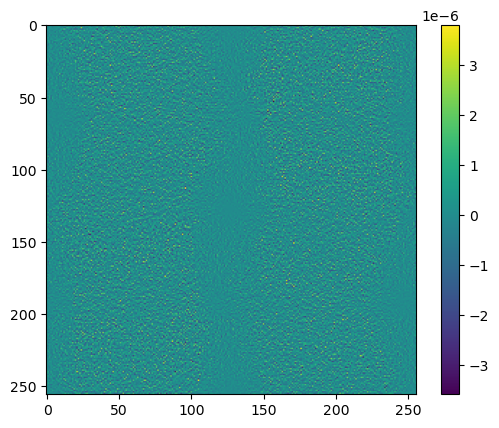

MINMOD
using CT? True
using CT? True
using CT? True


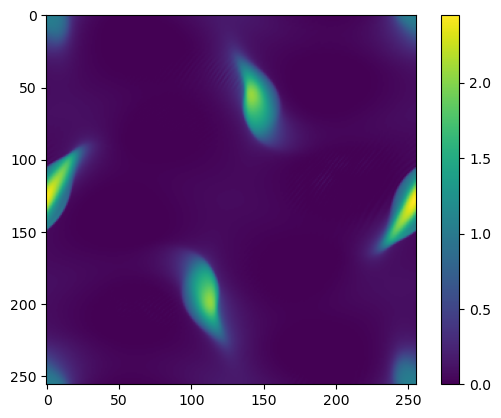

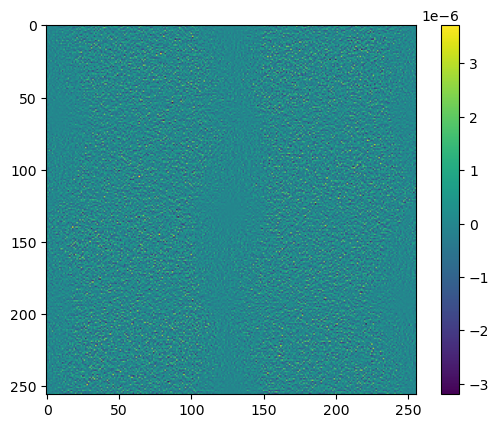

SUPERBEE
using CT? True
using CT? True
using CT? True


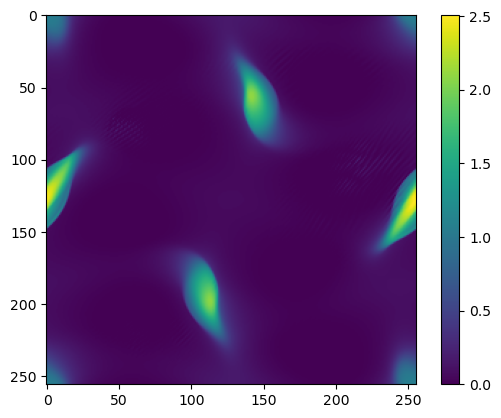

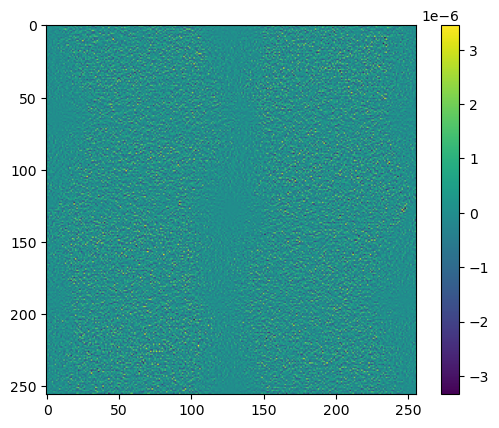

VANALBADA
using CT? True
using CT? True
using CT? True


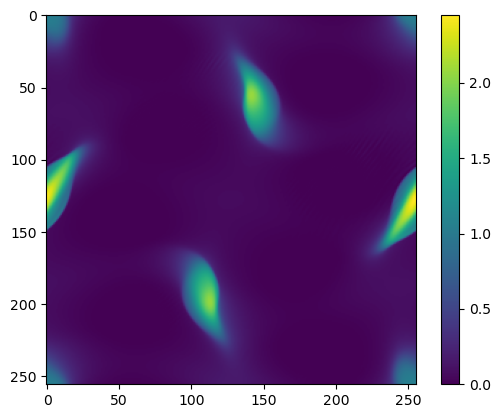

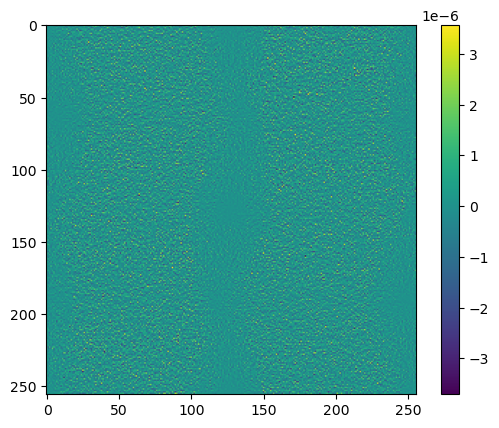

VANLEER
using CT? True
using CT? True
using CT? True


In [ ]:
def divB(U):
    Bx, By, Bz = U[4], U[5], U[6]
    dx = 1
    return ((Bx - jnp.roll(Bx, 1, axis=0)) +
            (By - jnp.roll(By, 1, axis=1)) +
            (Bz - jnp.roll(Bz, 1, axis=2))) / dx

eq.cfl= 0.1
solver = dh.HLLD_MHD(equation_manager=eq,signal_speed=None)

for key in dh.LIMITER_DICT.keys():
    print(key)
    cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter=key),positivity=True)

    hydro_baseline = dh.hydro_ct(n_super_step=1000, 
                                 fluxes=[cf],
                                 forces=[],
                                 use_mol=True,
                                 use_ct=True, 
                                 integrator="RK2") 
    params = {}
    #cons = eq.get_conservatives_from_primitives(prim)
   #try:
    output_baseline = hydro_baseline.evolve(IC,params)
    field_out = output_baseline[0]
    field_out_prim = eq.get_primitives_from_conservatives(field_out)
    imshow(field_out_prim[-1][:,:,0])
    plt.colorbar()
    plt.show()
    imshow(divB(field_out)) # ,vmin=-0.1,vmax=0.1)
    colorbar()
    show()
    
    #except:
    #    print("error!")
